# Image Memorability Analysis

This notebook analyzes image memorability using two different pre-trained models:
1. **ResMem**: A deep learning model specifically designed for memorability prediction
2. **MemNet**: A Caffe-based model for image memorability analysis

The analysis will provide memorability scores for each image, allowing for comparison between the two models and identification of highly memorable images.


## 1. Setup and Dependencies

First, let's install and import all necessary packages.


In [ ]:
# Install required packages
# %pip install resmem pandas pillow tqdm opencv-python numpy requests matplotlib seaborn


In [1]:
# Import required libraries
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


## 2. Configuration

Set up paths and parameters for the analysis.


In [12]:
# Configuration
class Config:
    # Image paths - Update these paths to your image folders
    stimuli_sets = {
        'stimuli1': r'..\psychophysics_WM\stimuli1',
        'stimuli2': r'..\psychophysics_WM\stimuli2'
    }
    
    # Categories
    categories = ['Animal', 'Car', 'Food', 'Person']
    
    # Item conditions based on file numbers
    item_conditions = {
        '1': range(10, 20),  # Files 10-19 (1 item)
        '5': range(20, 30)  # Files 20-29 (5 items)
    }
    
    # MemNet model paths
    memnet_prototxt = 'memnet/deploy.prototxt'
    memnet_model = 'memnet/memnet.caffemodel'
    
    # Image processing settings
    resize_method = 'stretch'  # Options: 'center_crop', 'resize_pad', 'stretch'
    use_consistent_preprocessing = True  # Use same preprocessing for both models for fair comparison
    
    # Output paths
    output_dir = 'results'
    memorability_scores_file = os.path.join(output_dir, 'all_memorability_scores.csv')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

config = Config()
print("Configuration:")
print(f"Stimuli sets: {list(config.stimuli_sets.keys())}")
print(f"Categories: {config.categories}")
print(f"Item conditions: {list(config.item_conditions.keys())}")
print(f"  - Single item (1): files {list(config.item_conditions['1'])}")
print(f"  - Multiple items (5): files {list(config.item_conditions['5'])}")
print(f"Output directory: {config.output_dir}")
print(f"Resize method: {config.resize_method}")
print(f"Consistent preprocessing: {config.use_consistent_preprocessing}")
print()
print("Resize method options:")
print("• 'center_crop': Scale and center crop (recommended, preserves aspect ratio)")
print("• 'resize_pad': Scale and pad with gray borders (preserves all content)")
print("• 'stretch': Simple stretch to 227x227 (may distort aspect ratio)")
print()
print("Preprocessing consistency:")
print(f"• True: Both models use same resizing method (fair comparison)")
print(f"• False: Each model uses its own built-in preprocessing")


Configuration:
Stimuli sets: ['stimuli1', 'stimuli2']
Categories: ['Animal', 'Car', 'Food', 'Person']
Item conditions: ['1', '5']
  - Single item (1): files [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  - Multiple items (5): files [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Output directory: results
Resize method: stretch
Consistent preprocessing: True

Resize method options:
• 'center_crop': Scale and center crop (recommended, preserves aspect ratio)
• 'resize_pad': Scale and pad with gray borders (preserves all content)
• 'stretch': Simple stretch to 227x227 (may distort aspect ratio)

Preprocessing consistency:
• True: Both models use same resizing method (fair comparison)
• False: Each model uses its own built-in preprocessing


## 3. ResMem Implementation

Load and set up the ResMem model for memorability prediction.


In [13]:
from resmem import ResMem, transformer
from torchvision import transforms

# Load ResMem model
resmem_model = ResMem(pretrained=True)
resmem_model.eval()

# ResMem preprocessing options
print("=" * 60)
print("RESMEM PREPROCESSING OPTIONS")
print("=" * 60)
print("ResMem typically uses its own preprocessing, but for fair comparison")
print("with MemNet, we can use consistent preprocessing for both models.")
print()
print("Options:")
print("1. use_builtin=True: Use ResMem's built-in transformer (default)")
print("2. use_builtin=False: Use same preprocessing as MemNet for fair comparison")
print("=" * 60)

def preprocess_image_resmem(image_path, resize_method='center_crop', use_builtin=True):
    """
    Preprocess image for ResMem model.
    
    Args:
        image_path (str): Path to input image
        resize_method (str): Method for resizing ('center_crop', 'resize_pad', 'stretch')
        use_builtin (bool): If True, use ResMem's built-in transformer; 
                           If False, use same preprocessing as MemNet
        
    Returns:
        torch.Tensor: Preprocessed image tensor ready for ResMem
    """
    if use_builtin:
        # Use ResMem's built-in preprocessing
        img = Image.open(image_path).convert('RGB')
        tensor = transformer(img).unsqueeze(0)
        return tensor
    else:
        # Use consistent preprocessing (same as MemNet but for PyTorch)
        img = Image.open(image_path).convert('RGB')
        
        # Use same smart resizing as MemNet - but need to check ResMem's expected size
        # Let's use the same 227x227 as MemNet for true consistency
        img = resize_image_smart(img, target_size=227, method=resize_method)
        
        # Convert to tensor and normalize (PyTorch format)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet RGB means
                               std=[0.229, 0.224, 0.225])     # ImageNet RGB stds
        ])
        
        tensor = transform(img).unsqueeze(0)
        return tensor

def predict_resmem(image_path, resize_method='center_crop', use_consistent_preprocessing=True):
    """
    Predict memorability score using ResMem model.
    
    Args:
        image_path (str): Path to input image
        resize_method (str): Method for resizing ('center_crop', 'resize_pad', 'stretch')
        use_consistent_preprocessing (bool): If True, use same preprocessing as MemNet;
                                           If False, use ResMem's built-in preprocessing
        
    Returns:
        float or None: Memorability score or None if error
    """
    try:
        img = Image.open(image_path).convert('RGB')
        
        if use_consistent_preprocessing:
            # Use same preprocessing as MemNet: intelligent resizing to 227x227
            img_resized = resize_image_smart(img, target_size=227, method=resize_method)
            
            # Apply ResMem's transformer to the resized image
            image_x = transformer(img_resized)
            
            # CRITICAL: Use the official ResMem reshape as shown in documentation
            # prediction = model(image_x.view(-1, 3, 227, 227))
            prediction = resmem_model(image_x.view(-1, 3, 227, 227))
        else:
            # Use ResMem's built-in preprocessing (original method)
            image_x = transformer(img)
            prediction = resmem_model(image_x.view(-1, 3, 227, 227))
        
        with torch.no_grad():
            score = prediction.item()
        return score
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

print("ResMem model loaded successfully!")


d:\WM_binding_git\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\WM_binding_git\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RESMEM PREPROCESSING OPTIONS
ResMem typically uses its own preprocessing, but for fair comparison
with MemNet, we can use consistent preprocessing for both models.

Options:
1. use_builtin=True: Use ResMem's built-in transformer (default)
2. use_builtin=False: Use same preprocessing as MemNet for fair comparison
ResMem model loaded successfully!


## 4. MemNet Implementation

Load and set up the MemNet model for memorability prediction.


In [14]:
# MemNet Preprocessing Requirements Documentation
print("=" * 60)
print("MEMNET PREPROCESSING REQUIREMENTS")
print("=" * 60)
print("MemNet is a Caffe-based model from MIT for image memorability prediction.")
print("Requirements for proper preprocessing:")
print()
print("1. INPUT SIZE: 227x227 pixels (fixed size)")
print("2. COLOR FORMAT: RGB -> BGR conversion required")
print("3. NORMALIZATION: Mean subtraction with ImageNet means")
print("4. DATA TYPE: Float32")
print("5. FORMAT: NCHW (Batch, Channels, Height, Width)")
print()
print("Preprocessing steps:")
print("- Load image as RGB")
print("- Resize to 227x227")
print("- Convert RGB to BGR (reverse channel order)")
print("- Subtract ImageNet BGR means: [104.0, 117.0, 123.0]")
print("- Convert to blob format for OpenCV DNN")
print("=" * 60)

# Load MemNet model (requires model files)
try:
    if not os.path.exists(config.memnet_prototxt) or not os.path.exists(config.memnet_model):
        print("Warning: MemNet model files not found.")
        print("To download MemNet model files:")
        print("1. Visit: http://memorability.csail.mit.edu/")
        print("2. Download deploy.prototxt and memnet.caffemodel")
        print("3. Place them in the 'memnet/' directory")
        print(f"Expected files: {config.memnet_prototxt}, {config.memnet_model}")
        memnet = None
    else:
        memnet = cv2.dnn.readNetFromCaffe(config.memnet_prototxt, config.memnet_model)
        print("MemNet model loaded successfully!")
except Exception as e:
    print(f"Error loading MemNet: {str(e)}")
    memnet = None

def resize_image_smart(img, target_size=227, method='center_crop'):
    """
    Resize image to target size using different methods to preserve quality.
    
    Args:
        img (PIL.Image): Input image
        target_size (int): Target size (227 for MemNet)
        method (str): Resizing method - 'center_crop', 'resize_pad', or 'stretch'
    
    Returns:
        PIL.Image: Resized image
    """
    width, height = img.size
    
    if method == 'center_crop':
        # Resize maintaining aspect ratio, then center crop
        # This is the most common approach for computer vision models
        
        # Calculate the scale to make the smaller dimension equal to target_size
        scale = max(target_size / width, target_size / height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        
        # Resize maintaining aspect ratio
        img = img.resize((new_width, new_height), Image.LANCZOS)
        
        # Center crop to target_size x target_size
        left = (new_width - target_size) // 2
        top = (new_height - target_size) // 2
        right = left + target_size
        bottom = top + target_size
        
        img = img.crop((left, top, right, bottom))
        
    elif method == 'resize_pad':
        # Resize maintaining aspect ratio, then pad to square
        # This preserves all content but may add borders
        
        # Calculate scale to fit within target_size x target_size
        scale = min(target_size / width, target_size / height)
        new_width = int(width * scale)
        new_height = int(height * scale)
        
        # Resize maintaining aspect ratio
        img = img.resize((new_width, new_height), Image.LANCZOS)
        
        # Create new image with target size and paste resized image in center
        new_img = Image.new('RGB', (target_size, target_size), (128, 128, 128))  # Gray padding
        paste_x = (target_size - new_width) // 2
        paste_y = (target_size - new_height) // 2
        new_img.paste(img, (paste_x, paste_y))
        img = new_img
        
    elif method == 'stretch':
        # Simple stretch to target size (can distort aspect ratio)
        img = img.resize((target_size, target_size), Image.LANCZOS)
        
    else:
        raise ValueError(f"Unknown resize method: {method}")
    
    return img

def preprocess_image_memnet(image_path, resize_method='center_crop'):
    """
    Preprocess image for MemNet model according to official requirements.
    
    MemNet preprocessing steps:
    1. Load and convert to RGB
    2. Resize to 227x227 pixels (using smart resizing)
    3. Convert to float32
    4. Convert RGB to BGR (OpenCV/Caffe format)
    5. Subtract ImageNet BGR means: [104.0, 117.0, 123.0]
    6. Convert to blob format (NCHW)
    
    Args:
        image_path (str): Path to input image
        resize_method (str): Method for resizing ('center_crop', 'resize_pad', 'stretch')
        
    Returns:
        np.ndarray: Preprocessed image blob ready for MemNet
    """
    # Load image as RGB
    img = Image.open(image_path).convert('RGB')
    
    # Smart resize to required input size
    img = resize_image_smart(img, target_size=227, method=resize_method)
    
    # Convert to numpy array and float32
    img = np.array(img).astype(np.float32)
    
    # Convert RGB to BGR (Caffe/OpenCV convention)
    img = img[:, :, ::-1]
    
    # Subtract ImageNet BGR means
    # These are the standard ImageNet means in BGR order
    mean = np.array([104.0, 117.0, 123.0])
    img -= mean
    
    # Convert to blob format (adds batch dimension and reorders to NCHW)
    blob = cv2.dnn.blobFromImage(img)
    
    return blob

def predict_memnet(image_path, resize_method='center_crop'):
    """
    Predict memorability score using MemNet model.
    
    Args:
        image_path (str): Path to input image
        resize_method (str): Method for resizing ('center_crop', 'resize_pad', 'stretch')
        
    Returns:
        float or None: Memorability score (0-1) or None if error
    """
    if memnet is None:
        return None
    try:
        # Preprocess image with specified resize method
        blob = preprocess_image_memnet(image_path, resize_method=resize_method)
        
        # Set input and run forward pass
        memnet.setInput(blob)
        pred = memnet.forward()
        
        # Extract memorability score
        score = float(pred[0][0])
        
        return score
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None


MEMNET PREPROCESSING REQUIREMENTS
MemNet is a Caffe-based model from MIT for image memorability prediction.
Requirements for proper preprocessing:

1. INPUT SIZE: 227x227 pixels (fixed size)
2. COLOR FORMAT: RGB -> BGR conversion required
3. NORMALIZATION: Mean subtraction with ImageNet means
4. DATA TYPE: Float32
5. FORMAT: NCHW (Batch, Channels, Height, Width)

Preprocessing steps:
- Load image as RGB
- Resize to 227x227
- Convert RGB to BGR (reverse channel order)
- Subtract ImageNet BGR means: [104.0, 117.0, 123.0]
- Convert to blob format for OpenCV DNN
MemNet model loaded successfully!


## 5. Image Processing and Analysis

Process images and calculate memorability scores using both models.


In [15]:
def process_all_images():
    """Process all images across sets, categories, and item conditions."""
    all_results = []
    total_images = 0
    
    # Count total images first
    for set_name, set_path in config.stimuli_sets.items():
        for category in config.categories:
            category_path = os.path.join(set_path, category)
            if os.path.exists(category_path):
                image_files = [f for f in os.listdir(category_path) 
                             if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                total_images += len(image_files)
    
    print(f"Found {total_images} total images to process")
    
    # Process all images with progress bar
    with tqdm(total=total_images, desc="Processing all images") as pbar:
        for set_name, set_path in config.stimuli_sets.items():
            if not os.path.exists(set_path):
                print(f"Warning: Stimuli set path '{set_path}' not found.")
                continue
                
            for category in config.categories:
                category_path = os.path.join(set_path, category)
                if not os.path.exists(category_path):
                    print(f"Warning: Category path '{category_path}' not found.")
                    continue
                
                image_files = [f for f in os.listdir(category_path) 
                             if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                
                for fname in image_files:
                    # Extract item number from filename (assumes format like 10.jpg, 21.png, etc)
                    try:
                        item_number = int(os.path.splitext(fname)[0])
                    except ValueError:
                        item_number = None
                    
                    # Determine item condition
                    item_condition = None
                    if item_number is not None:
                        for cond_name, cond_range in config.item_conditions.items():
                            if item_number in cond_range:
                                item_condition = cond_name
                                break
                    
                    image_path = os.path.join(category_path, fname)
                    
                    # Get predictions from both models
                    resmem_score = predict_resmem(
                        image_path,
                        resize_method=config.resize_method,
                        use_consistent_preprocessing=config.use_consistent_preprocessing
                    )
                    memnet_score = predict_memnet(
                        image_path,
                        resize_method=config.resize_method
                    )
                    
                    all_results.append({
                        'set': set_name,
                        'category': category,
                        'item_number': item_number,
                        'item_condition': item_condition,
                        'filename': fname,
                        'image_path': image_path,
                        'resmem_score': resmem_score,
                        'memnet_score': memnet_score
                    })
                    
                    pbar.update(1)
    
    return pd.DataFrame(all_results)

# Test path configuration first
print("Testing path configuration...")
for set_name, set_path in config.stimuli_sets.items():
    print(f"Checking {set_name}: {set_path}")
    if os.path.exists(set_path):
        print(f"  ✓ Path exists")
        for category in config.categories:
            category_path = os.path.join(set_path, category)
            if os.path.exists(category_path):
                image_files = [f for f in os.listdir(category_path) 
                             if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                print(f"    {category}: {len(image_files)} images")
            else:
                print(f"    {category}: Path not found")
    else:
        print(f"  ✗ Path not found")

print("\n" + "="*50)

# Process all images
print("Processing all images across stimuli sets, categories, and item conditions...")
df = process_all_images()

# Save results
if not df.empty:
    df.to_csv(config.memorability_scores_file, index=False)
    print(f"Results saved to: {config.memorability_scores_file}")
    print(f"Processed {len(df)} images total")
    
    # Display summary
    print("\nSummary:")
    print(f"Sets: {df['set'].value_counts().to_dict()}")
    print(f"Categories: {df['category'].value_counts().to_dict()}")
    print(f"Item conditions: {df['item_condition'].value_counts().to_dict()}")
    
    # Show first few rows
    print("\nFirst few rows:")
    display(df.head())
else:
    print("No results to display")


Testing path configuration...
Checking stimuli1: ..\psychophysics_WM\stimuli1
  ✓ Path exists
    Animal: 20 images
    Car: 20 images
    Food: 20 images
    Person: 20 images
Checking stimuli2: ..\psychophysics_WM\stimuli2
  ✓ Path exists
    Animal: 20 images
    Car: 20 images
    Food: 20 images
    Person: 20 images

Processing all images across stimuli sets, categories, and item conditions...
Found 160 total images to process


Processing all images: 100%|██████████| 160/160 [00:23<00:00,  6.96it/s]

Results saved to: results\all_memorability_scores.csv
Processed 160 images total

Summary:
Sets: {'stimuli1': 80, 'stimuli2': 80}
Categories: {'Animal': 40, 'Car': 40, 'Food': 40, 'Person': 40}
Item conditions: {'1': 80, '5': 80}

First few rows:


,set,category,item_number,item_condition,filename,image_path,resmem_score,memnet_score
0,stimuli1,Animal,10,1,10.jpg,..\psychophysics_WM\stimuli1\Animal\10.jpg,0.826324,0.781981
1,stimuli1,Animal,11,1,11.jpg,..\psychophysics_WM\stimuli1\Animal\11.jpg,0.751756,0.780630
2,stimuli1,Animal,12,1,12.jpg,..\psychophysics_WM\stimuli1\Animal\12.jpg,0.883863,0.754130
3,stimuli1,Animal,13,1,13.jpg,..\psychophysics_WM\stimuli1\Animal\13.jpg,0.781285,0.820306
4,stimuli1,Animal,14,1,14.jpg,..\psychophysics_WM\stimuli1\Animal\14.jpg,0.884561,0.850797


## 6. Results Analysis and Visualization

Analyze and visualize the memorability scores from both models.


MEMORABILITY ANALYSIS - ResMem (Main) + MemNet (Validation)

MODEL VALIDATION:
------------------------------
ResMem vs MemNet correlation:
  Pearson r = 0.582 (p = 0.000)
  Spearman ρ = 0.613 (p = 0.000)
  ✓ Good agreement between models - MemNet validates ResMem results

PRIMARY ANALYSIS (ResMem-based)

1. STIMULI SET COMPARISON (stimuli1 vs stimuli2)
--------------------------------------------------
PRIMARY ANALYSIS - ResMem Scores by Set:
              mean       std  count
set                                
stimuli1  0.831718  0.073747     80
stimuli2  0.805040  0.083345     80

VALIDATION - MemNet Scores by Set:
              mean       std  count
set                                
stimuli1  0.832380  0.046491     80
stimuli2  0.786796  0.086831     80

PRIMARY RESULT - ResMem t-test: t=2.144, p=0.034, Cohen's d=0.339
  → Stimuli1 has significantly higher memorability than Stimuli2
VALIDATION - MemNet t-test: t=4.139, p=0.000
  ✓ MemNet validation agrees with ResMem result


2

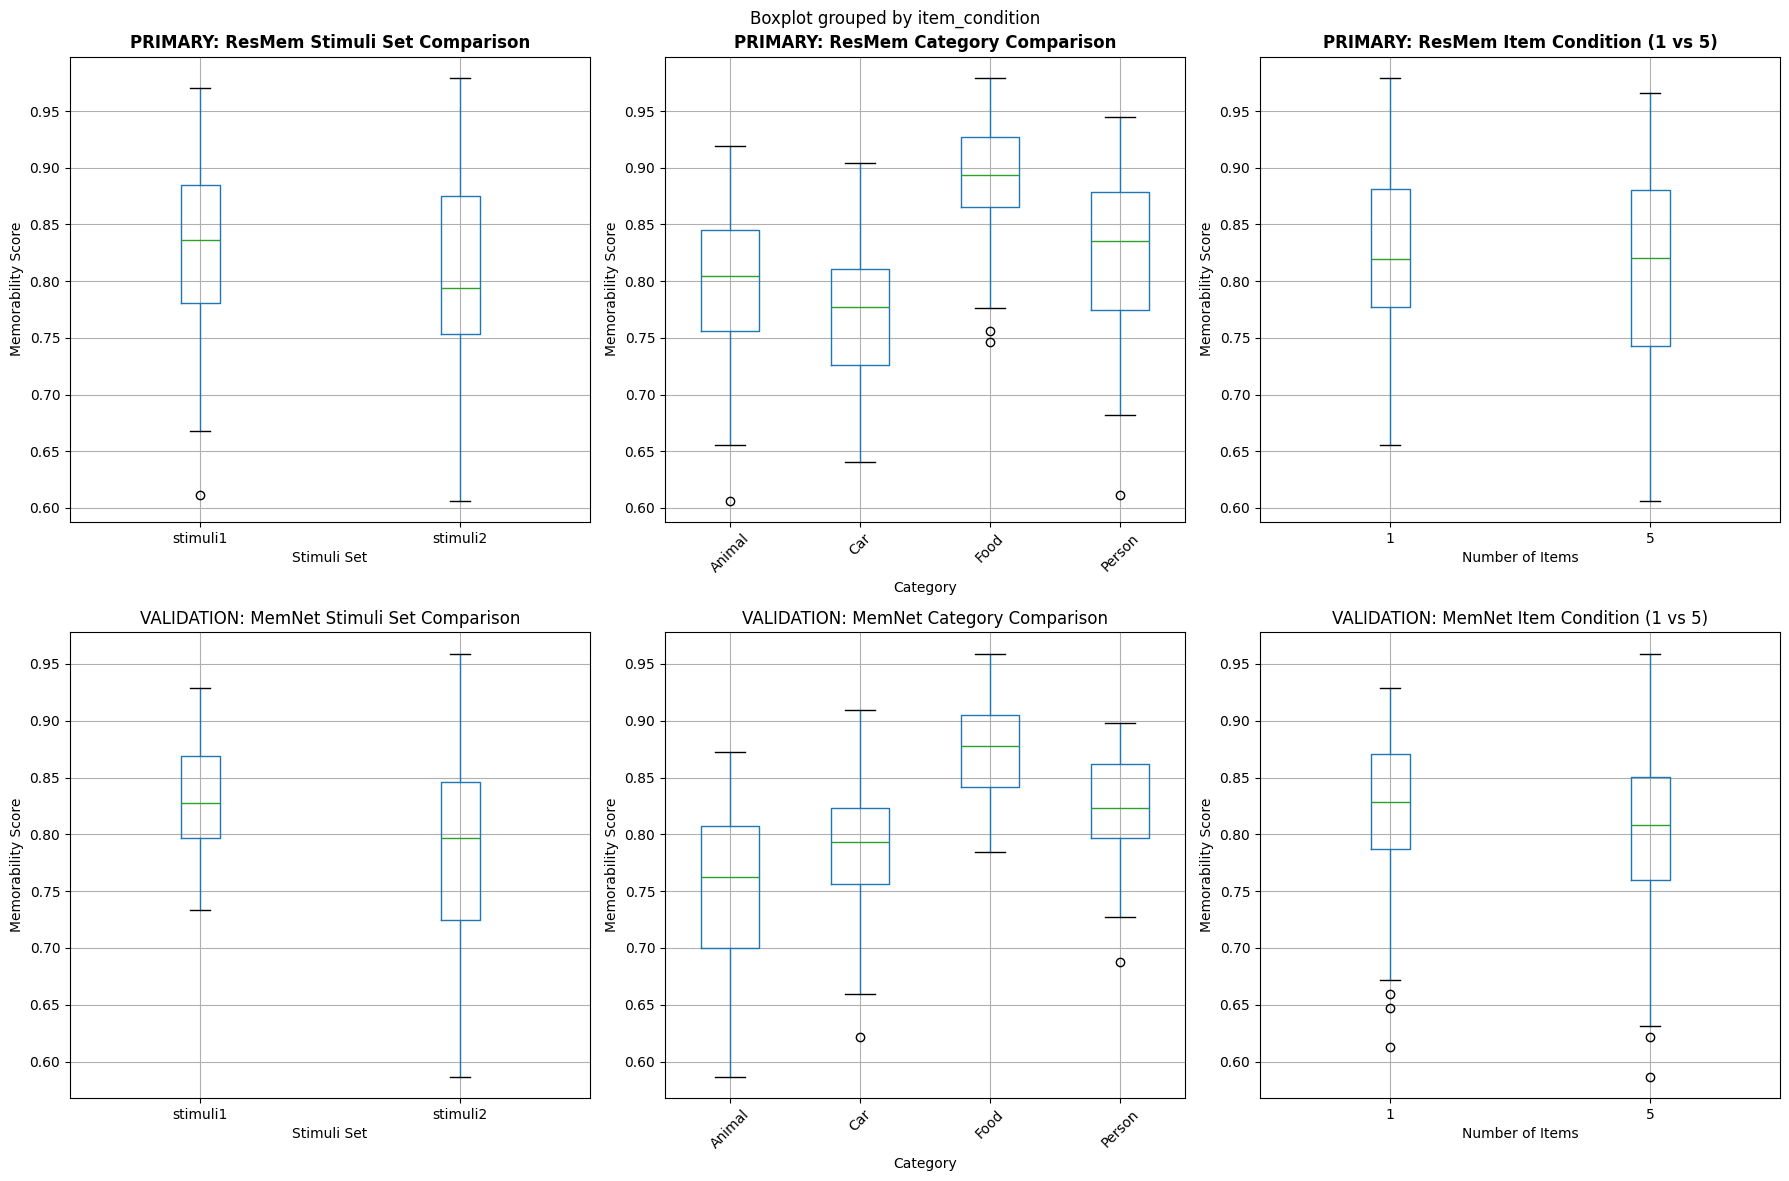



5. DETAILED BREAKDOWN
--------------------------------------------------
Detailed breakdown by Set × Category × Item Condition:
                                 resmem_score                 memnet_score  \
                                         mean       std count         mean   
set      category item_condition                                             
stimuli1 Animal   1                  0.828419  0.056298    10     0.815330   
                  5                  0.803357  0.041586    10     0.806832   
         Car      1                  0.762270  0.054613    10     0.812293   
                  5                  0.813343  0.077244    10     0.795213   
         Food     1                  0.888114  0.055777    10     0.883789   
                  5                  0.893941  0.068464    10     0.867892   
         Person   1                  0.853068  0.039940    10     0.857379   
                  5                  0.811228  0.095123    10     0.820314   
stimuli2 Ani

In [16]:
def analyze_memorability_differences(df):
    """
    Analyze memorability score differences using ResMem as main analysis tool:
    1. Stimuli sets (stimuli1 vs stimuli2)
    2. Categories (Animal, Car, Food, Person)
    3. Item conditions (1 item vs 5 items)
    
    MemNet is used for validation and comparison.
    """
    if df.empty:
        print("No data to analyze")
        return
    
    # Clean data
    df_clean = df.dropna(subset=['resmem_score', 'memnet_score'])
    
    if df_clean.empty:
        print("No valid data to analyze")
        return
    
    print("=" * 80)
    print("MEMORABILITY ANALYSIS - ResMem (Main) + MemNet (Validation)")
    print("=" * 80)
    
    # Model validation check
    print("\nMODEL VALIDATION:")
    print("-" * 30)
    
    # Check correlation between models for validation
    from scipy.stats import pearsonr, spearmanr
    if 'resmem_score' in df_clean.columns and 'memnet_score' in df_clean.columns:
        valid_both = df_clean.dropna(subset=['resmem_score', 'memnet_score'])
        if len(valid_both) > 1:
            pearson_r, pearson_p = pearsonr(valid_both['resmem_score'], valid_both['memnet_score'])
            spearman_r, spearman_p = spearmanr(valid_both['resmem_score'], valid_both['memnet_score'])
            
            print(f"ResMem vs MemNet correlation:")
            print(f"  Pearson r = {pearson_r:.3f} (p = {pearson_p:.3f})")
            print(f"  Spearman ρ = {spearman_r:.3f} (p = {spearman_p:.3f})")
            
            if spearman_r > 0.5:
                print("  ✓ Good agreement between models - MemNet validates ResMem results")
            elif spearman_r > 0.3:
                print("  ⚠ Moderate agreement between models - interpret with caution")
            else:
                print("  ⚠ Low agreement between models - results may be model-specific")
        else:
            print("  Insufficient data for model comparison")
    
    print("\n" + "=" * 80)
    print("PRIMARY ANALYSIS (ResMem-based)")
    print("=" * 80)
    
    # 1. STIMULI SET COMPARISON (ResMem primary analysis)
    print("\n1. STIMULI SET COMPARISON (stimuli1 vs stimuli2)")
    print("-" * 50)
    
    set_stats = df_clean.groupby('set')[['resmem_score', 'memnet_score']].agg(['mean', 'std', 'count'])
    print("PRIMARY ANALYSIS - ResMem Scores by Set:")
    print(set_stats['resmem_score'])
    print("\nVALIDATION - MemNet Scores by Set:")
    print(set_stats['memnet_score'])
    
    # Statistical test for set differences
    from scipy import stats
    stimuli1_resmem = df_clean[df_clean['set'] == 'stimuli1']['resmem_score']
    stimuli2_resmem = df_clean[df_clean['set'] == 'stimuli2']['resmem_score']
    stimuli1_memnet = df_clean[df_clean['set'] == 'stimuli1']['memnet_score']
    stimuli2_memnet = df_clean[df_clean['set'] == 'stimuli2']['memnet_score']
    
    if len(stimuli1_resmem) > 0 and len(stimuli2_resmem) > 0:
        t_stat_resmem, p_val_resmem = stats.ttest_ind(stimuli1_resmem, stimuli2_resmem)
        effect_size = (stimuli1_resmem.mean() - stimuli2_resmem.mean()) / np.sqrt((stimuli1_resmem.var() + stimuli2_resmem.var()) / 2)
        print(f"\nPRIMARY RESULT - ResMem t-test: t={t_stat_resmem:.3f}, p={p_val_resmem:.3f}, Cohen's d={effect_size:.3f}")
        
        # Interpretation
        if p_val_resmem < 0.05:
            direction = "higher" if stimuli1_resmem.mean() > stimuli2_resmem.mean() else "lower"
            print(f"  → Stimuli1 has significantly {direction} memorability than Stimuli2")
        else:
            print(f"  → No significant difference between stimulus sets")
        
    if len(stimuli1_memnet) > 0 and len(stimuli2_memnet) > 0:
        t_stat_memnet, p_val_memnet = stats.ttest_ind(stimuli1_memnet, stimuli2_memnet)
        print(f"VALIDATION - MemNet t-test: t={t_stat_memnet:.3f}, p={p_val_memnet:.3f}")
        
        # Check if validation agrees with primary result
        resmem_sig = p_val_resmem < 0.05 if len(stimuli1_resmem) > 0 and len(stimuli2_resmem) > 0 else False
        memnet_sig = p_val_memnet < 0.05
        if resmem_sig == memnet_sig:
            print("  ✓ MemNet validation agrees with ResMem result")
        else:
            print("  ⚠ MemNet validation disagrees with ResMem result")
    
    # 2. CATEGORY COMPARISON (ResMem primary analysis)
    print("\n\n2. CATEGORY COMPARISON (Animal, Car, Food, Person)")
    print("-" * 50)
    
    cat_stats = df_clean.groupby('category')[['resmem_score', 'memnet_score']].agg(['mean', 'std', 'count'])
    print("PRIMARY ANALYSIS - ResMem Scores by Category:")
    print(cat_stats['resmem_score'])
    print("\nVALIDATION - MemNet Scores by Category:")
    print(cat_stats['memnet_score'])
    
    # ANOVA for category differences
    categories = df_clean['category'].unique()
    if len(categories) > 2:
        resmem_by_cat = [df_clean[df_clean['category'] == cat]['resmem_score'].values for cat in categories]
        memnet_by_cat = [df_clean[df_clean['category'] == cat]['memnet_score'].values for cat in categories]
        
        f_stat_resmem, p_val_resmem = stats.f_oneway(*resmem_by_cat)
        f_stat_memnet, p_val_memnet = stats.f_oneway(*memnet_by_cat)
        
        print(f"\nPRIMARY RESULT - ResMem ANOVA: F={f_stat_resmem:.3f}, p={p_val_resmem:.3f}")
        if p_val_resmem < 0.05:
            print("  → Significant differences between categories detected")
            # Find which category has highest memorability
            category_means = df_clean.groupby('category')['resmem_score'].mean().sort_values(ascending=False)
            print(f"  → Category ranking (highest to lowest memorability):")
            for i, (cat, score) in enumerate(category_means.items(), 1):
                print(f"    {i}. {cat}: {score:.3f}")
        else:
            print("  → No significant differences between categories")
            
        print(f"VALIDATION - MemNet ANOVA: F={f_stat_memnet:.3f}, p={p_val_memnet:.3f}")
        
        # Check validation agreement
        resmem_cat_sig = p_val_resmem < 0.05
        memnet_cat_sig = p_val_memnet < 0.05
        if resmem_cat_sig == memnet_cat_sig:
            print("  ✓ MemNet validation agrees with ResMem result")
        else:
            print("  ⚠ MemNet validation disagrees with ResMem result")
    
    # 3. ITEM CONDITION COMPARISON (ResMem primary analysis)
    print("\n\n3. ITEM CONDITION COMPARISON (1 item vs 5 items)")
    print("-" * 50)
    
    # Filter only valid item conditions
    df_items = df_clean[df_clean['item_condition'].notna()]
    
    if not df_items.empty:
        item_stats = df_items.groupby('item_condition')[['resmem_score', 'memnet_score']].agg(['mean', 'std', 'count'])
        print("PRIMARY ANALYSIS - ResMem Scores by Item Condition:")
        print(item_stats['resmem_score'])
        print("\nVALIDATION - MemNet Scores by Item Condition:")
        print(item_stats['memnet_score'])
        
        # Statistical test for item condition differences
        single_resmem = df_items[df_items['item_condition'] == '1']['resmem_score']
        multiple_resmem = df_items[df_items['item_condition'] == '5']['resmem_score']
        single_memnet = df_items[df_items['item_condition'] == '1']['memnet_score']
        multiple_memnet = df_items[df_items['item_condition'] == '5']['memnet_score']
        
        if len(single_resmem) > 0 and len(multiple_resmem) > 0:
            t_stat_resmem, p_val_resmem = stats.ttest_ind(single_resmem, multiple_resmem)
            effect_size = (single_resmem.mean() - multiple_resmem.mean()) / np.sqrt((single_resmem.var() + multiple_resmem.var()) / 2)
            print(f"\nPRIMARY RESULT - ResMem t-test: t={t_stat_resmem:.3f}, p={p_val_resmem:.3f}, Cohen's d={effect_size:.3f}")
            
            # Interpretation
            if p_val_resmem < 0.05:
                direction = "higher" if single_resmem.mean() > multiple_resmem.mean() else "lower"
                print(f"  → Single-item images have significantly {direction} memorability than multiple-item images")
            else:
                print(f"  → No significant difference between item conditions")
            
        if len(single_memnet) > 0 and len(multiple_memnet) > 0:
            t_stat_memnet, p_val_memnet = stats.ttest_ind(single_memnet, multiple_memnet)
            print(f"VALIDATION - MemNet t-test: t={t_stat_memnet:.3f}, p={p_val_memnet:.3f}")
            
            # Check validation agreement
            resmem_item_sig = p_val_resmem < 0.05 if len(single_resmem) > 0 and len(multiple_resmem) > 0 else False
            memnet_item_sig = p_val_memnet < 0.05
            if resmem_item_sig == memnet_item_sig:
                print("  ✓ MemNet validation agrees with ResMem result")
            else:
                print("  ⚠ MemNet validation disagrees with ResMem result")
    else:
        print("No valid item condition data found")
    
    # 4. VISUALIZATION OF PRIMARY RESULTS
    print("\n\n4. VISUALIZATION OF PRIMARY RESULTS (ResMem-based)")
    print("-" * 50)
    
    # Create primary analysis plots (ResMem focused)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Memorability Analysis: ResMem (Primary) vs MemNet (Validation)', fontsize=16, fontweight='bold')
    
    # Set comparison
    df_clean.boxplot(column='resmem_score', by='set', ax=axes[0,0])
    axes[0,0].set_title('PRIMARY: ResMem Stimuli Set Comparison', fontweight='bold')
    axes[0,0].set_xlabel('Stimuli Set')
    axes[0,0].set_ylabel('Memorability Score')
    
    df_clean.boxplot(column='memnet_score', by='set', ax=axes[1,0])
    axes[1,0].set_title('VALIDATION: MemNet Stimuli Set Comparison')
    axes[1,0].set_xlabel('Stimuli Set')
    axes[1,0].set_ylabel('Memorability Score')
    
    # Category comparison
    df_clean.boxplot(column='resmem_score', by='category', ax=axes[0,1])
    axes[0,1].set_title('PRIMARY: ResMem Category Comparison', fontweight='bold')
    axes[0,1].set_xlabel('Category')
    axes[0,1].set_ylabel('Memorability Score')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    df_clean.boxplot(column='memnet_score', by='category', ax=axes[1,1])
    axes[1,1].set_title('VALIDATION: MemNet Category Comparison')
    axes[1,1].set_xlabel('Category')
    axes[1,1].set_ylabel('Memorability Score')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # Item condition comparison
    if not df_items.empty:
        df_items.boxplot(column='resmem_score', by='item_condition', ax=axes[0,2])
        axes[0,2].set_title('PRIMARY: ResMem Item Condition (1 vs 5)', fontweight='bold')
        axes[0,2].set_xlabel('Number of Items')
        axes[0,2].set_ylabel('Memorability Score')
        
        df_items.boxplot(column='memnet_score', by='item_condition', ax=axes[1,2])
        axes[1,2].set_title('VALIDATION: MemNet Item Condition (1 vs 5)')
        axes[1,2].set_xlabel('Number of Items')
        axes[1,2].set_ylabel('Memorability Score')
    else:
        axes[0,2].text(0.5, 0.5, 'No item condition data', ha='center', va='center')
        axes[0,2].set_title('PRIMARY: ResMem Item Condition', fontweight='bold')
        axes[1,2].text(0.5, 0.5, 'No item condition data', ha='center', va='center')
        axes[1,2].set_title('VALIDATION: MemNet Item Condition')
    
    plt.tight_layout()
    plt.show()
    
    # 5. DETAILED BREAKDOWN
    print("\n\n5. DETAILED BREAKDOWN")
    print("-" * 50)
    
    # Create a comprehensive breakdown table
    breakdown = df_clean.groupby(['set', 'category', 'item_condition'])[['resmem_score', 'memnet_score']].agg(['mean', 'std', 'count'])
    print("Detailed breakdown by Set × Category × Item Condition:")
    print(breakdown)
    
    # 6. SUMMARY OF KEY FINDINGS (ResMem-based)
    print("\n\n" + "=" * 80)
    print("SUMMARY OF KEY FINDINGS (ResMem-based Analysis)")
    print("=" * 80)
    
    # Overall ResMem statistics
    overall_mean = df_clean['resmem_score'].mean()
    overall_std = df_clean['resmem_score'].std()
    print(f"Overall ResMem memorability: {overall_mean:.3f} ± {overall_std:.3f}")
    
    # Set differences
    set_means = df_clean.groupby('set')['resmem_score'].mean()
    if len(set_means) == 2:
        set1, set2 = set_means.index
        diff = set_means[set1] - set_means[set2]
        print(f"\nStimuli Set Difference:")
        print(f"  {set1}: {set_means[set1]:.3f}")
        print(f"  {set2}: {set_means[set2]:.3f}")
        print(f"  Difference: {diff:.3f} ({set1} - {set2})")
    
    # Category ranking
    cat_means = df_clean.groupby('category')['resmem_score'].mean().sort_values(ascending=False)
    print(f"\nCategory Memorability Ranking (ResMem):")
    for i, (cat, score) in enumerate(cat_means.items(), 1):
        print(f"  {i}. {cat}: {score:.3f}")
    
    # Item condition differences
    if not df_items.empty:
        item_means = df_items.groupby('item_condition')['resmem_score'].mean()
        if len(item_means) == 2:
            single_score = item_means.get('1', 0)
            multiple_score = item_means.get('5', 0)
            diff = single_score - multiple_score
            print(f"\nItem Condition Difference:")
            print(f"  Single item (1): {single_score:.3f}")
            print(f"  Multiple items (5): {multiple_score:.3f}")
            print(f"  Difference: {diff:.3f} (single - multiple)")
    
    print("\nNote: All primary findings are based on ResMem analysis.")
    print("MemNet results are provided for validation purposes.")
    
    return df_clean

# Run the comprehensive analysis
if 'df' in globals() and not df.empty:
    analyzed_df = analyze_memorability_differences(df)
else:
    print("No data to analyze. Please run the image processing cell first.")


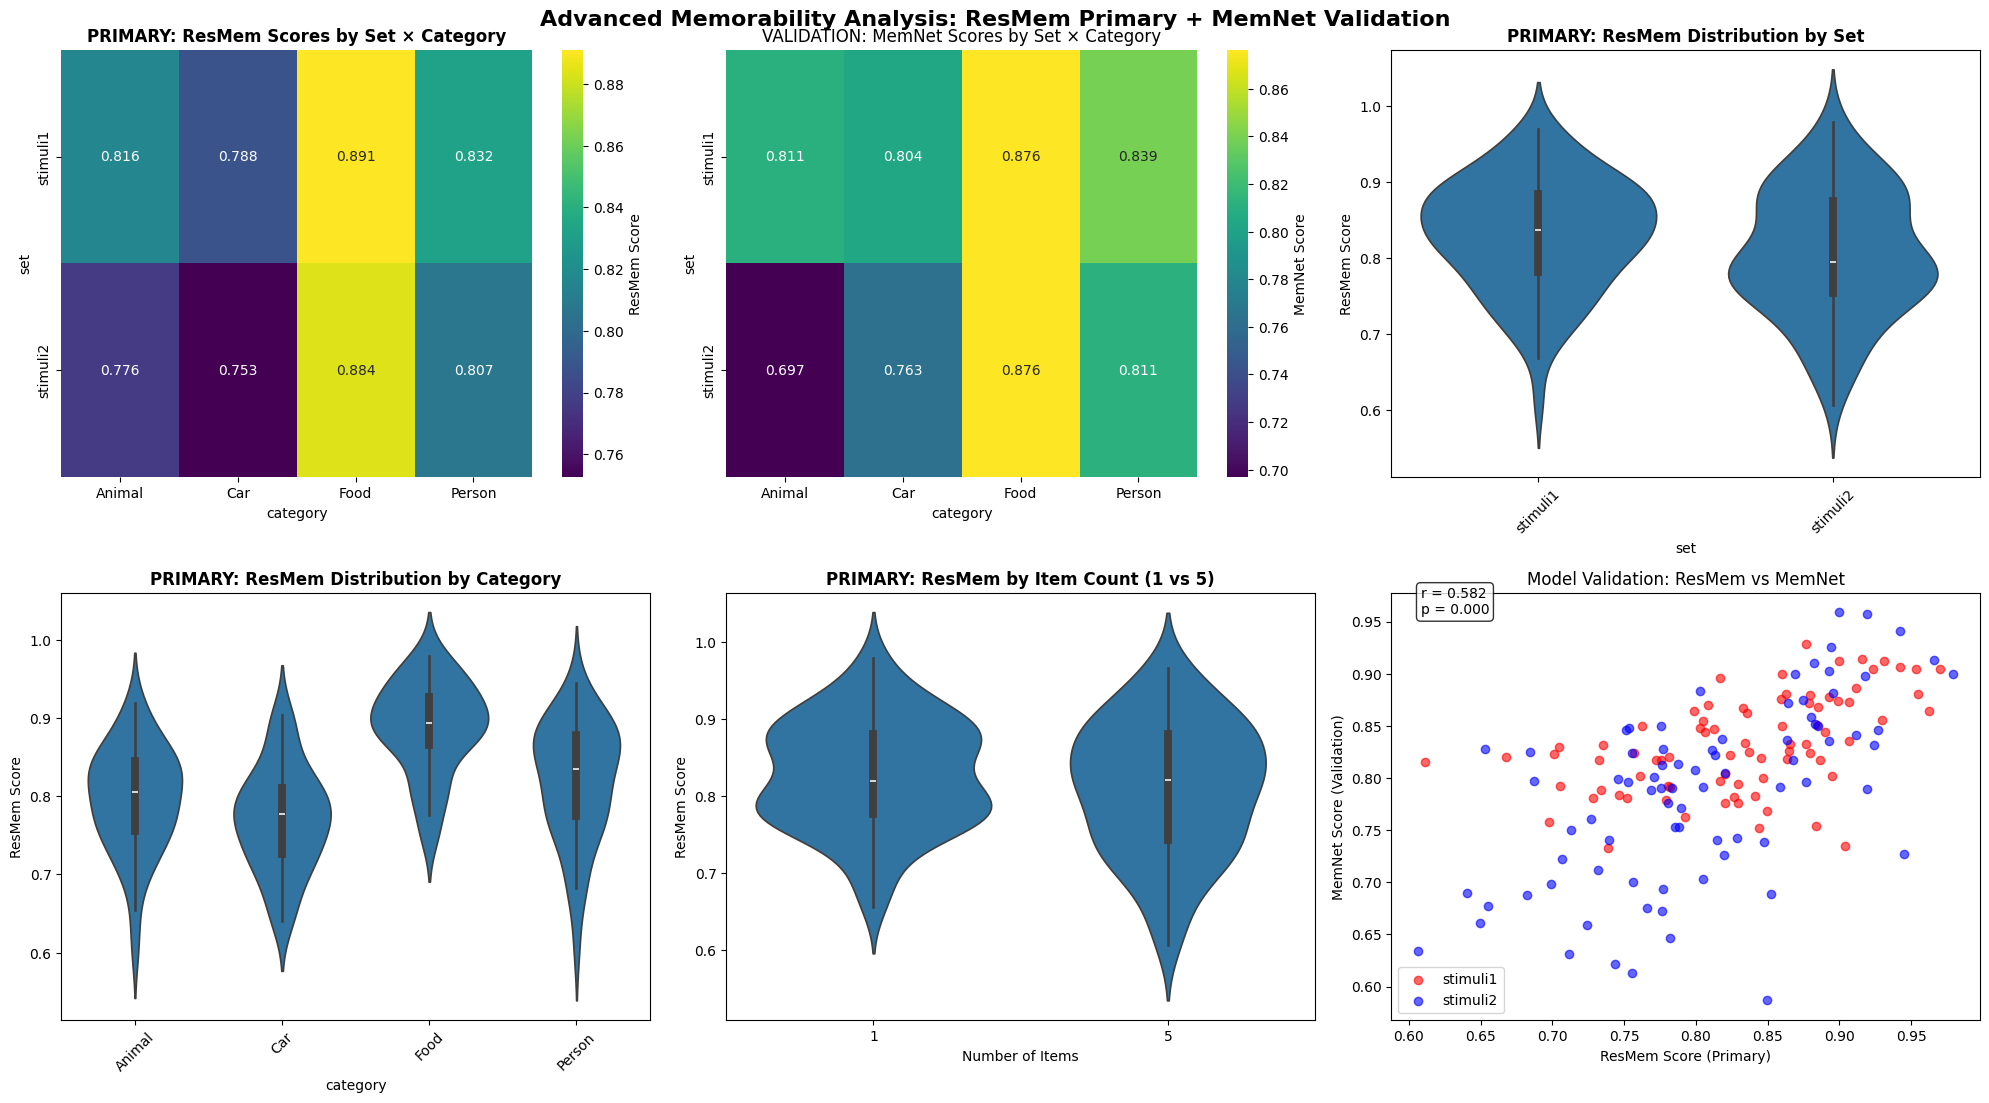

In [17]:
def create_advanced_visualizations(df):
    """Create advanced visualizations focusing on ResMem as primary analysis tool."""
    if df.empty:
        print("No data to visualize")
        return
    
    df_clean = df.dropna(subset=['resmem_score', 'memnet_score'])
    
    # Create ResMem-focused visualization
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle('Advanced Memorability Analysis: ResMem Primary + MemNet Validation', fontsize=16, fontweight='bold')
    
    # 1. Heatmap of mean scores by set and category (ResMem primary)
    plt.subplot(3, 3, 1)
    pivot_resmem = df_clean.pivot_table(values='resmem_score', index='set', columns='category', aggfunc='mean')
    sns.heatmap(pivot_resmem, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'ResMem Score'})
    plt.title('PRIMARY: ResMem Scores by Set × Category', fontweight='bold')
    
    plt.subplot(3, 3, 2)
    pivot_memnet = df_clean.pivot_table(values='memnet_score', index='set', columns='category', aggfunc='mean')
    sns.heatmap(pivot_memnet, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'MemNet Score'})
    plt.title('VALIDATION: MemNet Scores by Set × Category')
    
    # 2. ResMem distribution analysis (primary focus)
    plt.subplot(3, 3, 3)
    sns.violinplot(data=df_clean, x='set', y='resmem_score')
    plt.title('PRIMARY: ResMem Distribution by Set', fontweight='bold')
    plt.ylabel('ResMem Score')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 3, 4)
    sns.violinplot(data=df_clean, x='category', y='resmem_score')
    plt.title('PRIMARY: ResMem Distribution by Category', fontweight='bold')
    plt.ylabel('ResMem Score')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 3, 5)
    df_items = df_clean[df_clean['item_condition'].notna()]
    if not df_items.empty:
        sns.violinplot(data=df_items, x='item_condition', y='resmem_score')
        plt.title('PRIMARY: ResMem by Item Count (1 vs 5)', fontweight='bold')
        plt.xlabel('Number of Items')
        plt.ylabel('ResMem Score')
    else:
        plt.text(0.5, 0.5, 'No item condition data', ha='center', va='center')
        plt.title('PRIMARY: ResMem by Item Count', fontweight='bold')
    
    # 3. Model validation scatter plot
    plt.subplot(3, 3, 6)
    colors = {'stimuli1': 'red', 'stimuli2': 'blue'}
    for set_name in df_clean['set'].unique():
        subset = df_clean[df_clean['set'] == set_name]
        plt.scatter(subset['resmem_score'], subset['memnet_score'], 
                   alpha=0.6, label=set_name, color=colors.get(set_name, 'gray'))
    plt.xlabel('ResMem Score (Primary)')
    plt.ylabel('MemNet Score (Validation)')
    plt.title('Model Validation: ResMem vs MemNet')
    plt.legend()
    
    # Add correlation info
    from scipy.stats import pearsonr
    r, p = pearsonr(df_clean['resmem_score'], df_clean['memnet_score'])
    plt.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Run advanced visualizations
if 'df' in globals() and not df.empty:
    create_advanced_visualizations(df)
else:
    print("No data to visualize. Please run the image processing cell first.")


Basic Statistics:
       resmem_score  memnet_score
count    160.000000    160.000000
mean       0.818379      0.809588
std        0.079578      0.073094
min        0.606287      0.586732
25%        0.765160      0.776279
50%        0.819921      0.819904
75%        0.880418      0.856169
max        0.979347      0.959085

Valid scores - ResMem: 160, MemNet: 160
Pearson correlation (linear): 0.582
Spearman rank correlation: 0.613

Rank correlation interpretation: Moderate
→ This measures how well the models agree on relative ordering of images

Ranking Analysis:
Top 3 images with highest ranking agreement:
  22.jpg: ResMem rank 35, MemNet rank 35 (diff: 0)
  23.jpg: ResMem rank 134, MemNet rank 134 (diff: 0)
  22.jpg: ResMem rank 77, MemNet rank 78 (diff: 1)
Top 3 images with highest ranking disagreement:
  19.jpg: ResMem rank 7, MemNet rank 139 (diff: 132)
  21.jpg: ResMem rank 23, MemNet rank 137 (diff: 114)
  26.jpg: ResMem rank 62, MemNet rank 160 (diff: 98)


C:\Users\zhuj3\AppData\Local\Temp\ipykernel_7312\4262158541.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


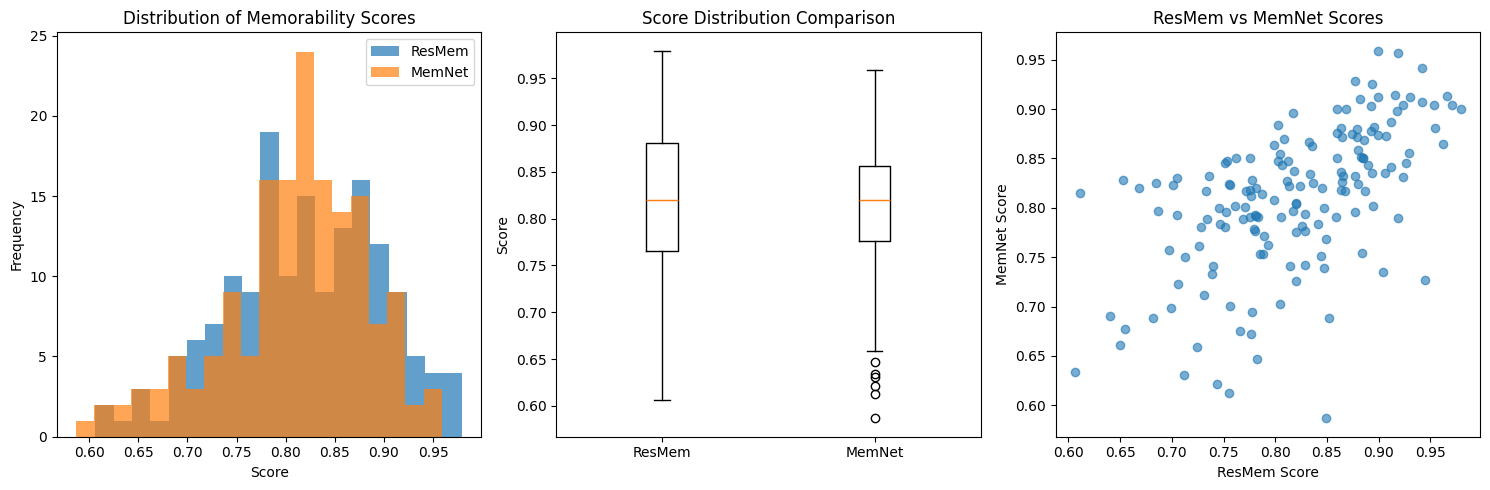

In [18]:
def analyze_results(df):
    """Analyze and visualize memorability scores."""
    if df.empty:
        print("No data to analyze")
        return df
    
    # Remove rows with missing scores
    df_clean = df.dropna()
    
    if df_clean.empty:
        print("No valid data to analyze")
        return df
    
    # Basic statistics
    print("Basic Statistics:")
    print(df_clean[['resmem_score', 'memnet_score']].describe())
    
    # Check if both models have valid scores
    resmem_valid = df_clean['resmem_score'].notna().sum()
    memnet_valid = df_clean['memnet_score'].notna().sum()
    
    print(f"\nValid scores - ResMem: {resmem_valid}, MemNet: {memnet_valid}")
    
    # Spearman rank correlation between models (if both have valid scores)
    if resmem_valid > 0 and memnet_valid > 0:
        df_both = df_clean.dropna(subset=['resmem_score', 'memnet_score'])
        if len(df_both) > 1:
            # Calculate both Pearson and Spearman correlations for comparison
            pearson_corr = df_both['resmem_score'].corr(df_both['memnet_score'], method='pearson')
            spearman_corr = df_both['resmem_score'].corr(df_both['memnet_score'], method='spearman')
            
            print(f"Pearson correlation (linear): {pearson_corr:.3f}")
            print(f"Spearman rank correlation: {spearman_corr:.3f}")
            print()
            
            # Interpret the Spearman correlation
            if spearman_corr >= 0.7:
                rank_strength = "Strong"
            elif spearman_corr >= 0.4:
                rank_strength = "Moderate"
            elif spearman_corr >= 0.2:
                rank_strength = "Weak"
            else:
                rank_strength = "Very weak"
            
            print(f"Rank correlation interpretation: {rank_strength}")
            print("→ This measures how well the models agree on relative ordering of images")
            
            # Add ranking analysis
            print(f"\nRanking Analysis:")
            df_both['resmem_rank'] = df_both['resmem_score'].rank(ascending=False)
            df_both['memnet_rank'] = df_both['memnet_score'].rank(ascending=False)
            df_both['rank_diff'] = abs(df_both['resmem_rank'] - df_both['memnet_rank'])
            
            # Show images with highest agreement (small rank differences)
            high_agreement = df_both.nsmallest(3, 'rank_diff')
            print("Top 3 images with highest ranking agreement:")
            for _, row in high_agreement.iterrows():
                print(f"  {row['filename']}: ResMem rank {row['resmem_rank']:.0f}, MemNet rank {row['memnet_rank']:.0f} (diff: {row['rank_diff']:.0f})")
            
            # Show images with highest disagreement (large rank differences)
            high_disagreement = df_both.nlargest(3, 'rank_diff')
            print("Top 3 images with highest ranking disagreement:")
            for _, row in high_disagreement.iterrows():
                print(f"  {row['filename']}: ResMem rank {row['resmem_rank']:.0f}, MemNet rank {row['memnet_rank']:.0f} (diff: {row['rank_diff']:.0f})")
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Distribution of scores
    plt.subplot(1, 3, 1)
    if resmem_valid > 0:
        plt.hist(df_clean['resmem_score'].dropna(), alpha=0.7, label='ResMem', bins=20)
    if memnet_valid > 0:
        plt.hist(df_clean['memnet_score'].dropna(), alpha=0.7, label='MemNet', bins=20)
    plt.title('Distribution of Memorability Scores')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Box plot
    plt.subplot(1, 3, 2)
    data_to_plot = []
    labels = []
    if resmem_valid > 0:
        data_to_plot.append(df_clean['resmem_score'].dropna())
        labels.append('ResMem')
    if memnet_valid > 0:
        data_to_plot.append(df_clean['memnet_score'].dropna())
        labels.append('MemNet')
    
    if data_to_plot:
        plt.boxplot(data_to_plot, labels=labels)
        plt.title('Score Distribution Comparison')
        plt.ylabel('Score')
    
    # Scatter plot (if both models have data)
    plt.subplot(1, 3, 3)
    if resmem_valid > 0 and memnet_valid > 0:
        df_both = df_clean.dropna(subset=['resmem_score', 'memnet_score'])
        if len(df_both) > 0:
            plt.scatter(df_both['resmem_score'], df_both['memnet_score'], alpha=0.6)
            plt.xlabel('ResMem Score')
            plt.ylabel('MemNet Score')
            plt.title('ResMem vs MemNet Scores')
    else:
        plt.text(0.5, 0.5, 'Need both models\nfor comparison', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Model Comparison')
    
    plt.tight_layout()
    plt.show()
    
    return df_clean

# Analyze results if data exists
if 'df' in globals() and not df.empty:
    analyzed_df = analyze_results(df)
else:
    print("No data to analyze. Please run the image processing cell first.")


## 7. correlation with performance

In [20]:
# Get all CSV files in the current directory and sort them
csv_files = sorted([f for f in os.listdir('.') if f.endswith('.csv')])
print("Available CSV files:", csv_files)
# Create a dictionary to store dataframes
dfs = {}

# Read each CSV file and store in the dictionary
for csv_file in csv_files:
    # Get name without .csv extension to use as key
    name = csv_file.replace('.csv', '')
    # Read the CSV file into a dataframe
    dfs[name] = pd.read_csv(csv_file)
    print(f"Loaded {csv_file}")

Available CSV files: ['P106_behfile.csv', 'P107_behfile.csv', 'P108_behfile.csv', 'P108_behfile_1.csv']
Loaded P106_behfile.csv
Loaded P107_behfile.csv
Loaded P108_behfile.csv
Loaded P108_behfile_1.csv


In [21]:
# Process all dataframes
for df_name, df in dfs.items():
    print(f"\nProcessing dataframe: {df_name}")
    # Ensure the relevant columns are numeric
    df['rt'] = pd.to_numeric(df['rt'], errors='coerce')
    df['acc'] = pd.to_numeric(df['acc'], errors='coerce')

    # Ensure first_pic and second_pic are strings so we can extract the last two digits
    df['first_pic'] = df['first_pic'].astype(str)
    df['second_pic'] = df['second_pic'].astype(str)

    # Define a function to extract the number from a picture ID
    def extract_number(pic_val):
        try:
            # Convert the picture value to float and then to int
            pic_int = int(float(pic_val))
            pic_str = str(pic_int)
            # Extract the last two digits
            last_two = int(pic_str[-2:])
        except Exception as e:
            return np.nan
        # Apply the rule: 10-19 -> 1, 20-29 -> 5; otherwise NaN
        if 10 <= last_two <= 19:
            return 1
        elif 20 <= last_two <= 29:
            return 5
        else:
            return np.nan

    # Generate first_num and second_num based on first_pic and second_pic
    df['first_num'] = df['first_pic'].apply(extract_number)
    df['second_num'] = df['second_pic'].apply(extract_number)
    
    # Update the dataframe in the dictionary
    dfs[df_name] = df


Processing dataframe: P106_behfile

Processing dataframe: P107_behfile

Processing dataframe: P108_behfile

Processing dataframe: P108_behfile_1


In [25]:
# Map numeric category codes to their semantic labels
category_map = {
    1: 'person',
    2: 'animal',
    3: 'food',
    4: 'car'
}

# Process each session's data
for df_name, df in dfs.items():
    # Validate dataframe type and convert columns to numeric
    if isinstance(df, pd.DataFrame):
        # Convert key columns to numeric type, handling any conversion errors
        df['acc'] = pd.to_numeric(df['acc'], errors='coerce')
        df['probe_validity'] = pd.to_numeric(df['probe_validity'], errors='coerce')
        df['first_cat'] = pd.to_numeric(df['first_cat'], errors='coerce')
        df['second_cat'] = pd.to_numeric(df['second_cat'], errors='coerce')
        df['correct_answer'] = pd.to_numeric(df['correct_answer'], errors='coerce')
        
        # Display current session being analyzed
        print(f"\nAnalyzing session: {df_name}")
            
        # Calculate and display overall performance metrics
        overall_accuracy = df['acc'].mean() * 100
        print("Overall Accuracy Rate: {:.2f}%".format(overall_accuracy))

        # Analyze accuracy patterns by first stimulus category
        acc_by_first_cat = df.groupby('first_cat')['acc'].mean() * 100
        print("\nAccuracy by First Category:")
        for cat_num, acc in acc_by_first_cat.items():
            print(f"{category_map[cat_num]}: {acc:.2f}%")

        # Analyze accuracy patterns by second stimulus category
        acc_by_second_cat = df.groupby('second_cat')['acc'].mean() * 100
        print("\nAccuracy by Second Category:")
        for cat_num, acc in acc_by_second_cat.items():
            print(f"{category_map[cat_num]}: {acc:.2f}%")

        # Analyze accuracy patterns by which picture was probed
        acc_by_probed_pic = df.groupby('probe_pic')['acc'].mean() * 100
        print("\nAccuracy by Probed Picture:")
        for pic_num, acc in acc_by_probed_pic.items():
            print(f"Picture {pic_num}: {acc:.2f}%")

        # Analyze interaction between category and probe picture
        # For first picture probes
        acc_by_cat_pic1 = df[df['probe_pic'] == 1].groupby('first_cat')['acc'].mean() * 100
        print("\nAccuracy by First Category (Probe Picture 1):")
        for cat_num, acc in acc_by_cat_pic1.items():
            print(f"{category_map[cat_num]}: {acc:.2f}%")
            
        # For second picture probes
        acc_by_cat_pic2 = df[df['probe_pic'] == 2].groupby('first_cat')['acc'].mean() * 100
        print("\nAccuracy by First Category (Probe Picture 2):")
        for cat_num, acc in acc_by_cat_pic2.items():
            print(f"{category_map[cat_num]}: {acc:.2f}%")

        # For first picture probes (second category)
        acc_by_cat_pic1_sec = df[df['probe_pic'] == 1].groupby('second_cat')['acc'].mean() * 100
        print("\nAccuracy by Second Category (Probe Picture 1):")
        for cat_num, acc in acc_by_cat_pic1_sec.items():
            print(f"{category_map[cat_num]}: {acc:.2f}%")
            
        # For second picture probes (second category)
        acc_by_cat_pic2_sec = df[df['probe_pic'] == 2].groupby('second_cat')['acc'].mean() * 100
        print("\nAccuracy by Second Category (Probe Picture 2):")
        for cat_num, acc in acc_by_cat_pic2_sec.items():
            print(f"{category_map[cat_num]}: {acc:.2f}%")



Analyzing session: P106_behfile
Overall Accuracy Rate: 89.58%

Accuracy by First Category:
person: 93.06%
animal: 88.89%
food: 93.06%
car: 83.33%

Accuracy by Second Category:
person: 93.06%
animal: 94.44%
food: 86.11%
car: 84.72%

Accuracy by Probed Picture:
Picture 1.0: 91.67%
Picture 2.0: 87.50%

Accuracy by First Category (Probe Picture 1):
person: 94.29%
animal: 97.06%
food: 96.97%
car: 80.95%

Accuracy by First Category (Probe Picture 2):
person: 91.89%
animal: 81.58%
food: 89.74%
car: 86.67%

Accuracy by Second Category (Probe Picture 1):
person: 94.12%
animal: 93.75%
food: 89.74%
car: 89.74%

Accuracy by Second Category (Probe Picture 2):
person: 92.11%
animal: 95.00%
food: 81.82%
car: 78.79%

Analyzing session: P107_behfile
Overall Accuracy Rate: 65.28%

Accuracy by First Category:
person: 69.44%
animal: 65.28%
food: 68.06%
car: 58.33%

Accuracy by Second Category:
person: 73.61%
animal: 62.50%
food: 61.11%
car: 63.89%

Accuracy by Probed Picture:
Picture 1.0: 63.19%
Picture 

In [26]:
def parse_accuracy_data():
    """
    Parse the accuracy data from behavioral sessions and create a structured DataFrame.
    This function creates sample data based on the provided accuracy results.
    """
    # Sample accuracy data based on the provided sessions
    accuracy_data = {
        'session': ['P106_behfile', 'P107_behfile', 'P108_behfile', 'P108_behfile_1'],
        'overall_accuracy': [89.58, 65.28, 89.93, 83.68],
        
        # Accuracy by First Category
        'person_first': [93.06, 69.44, 94.44, 84.72],
        'animal_first': [88.89, 65.28, 90.28, 88.89],
        'food_first': [93.06, 68.06, 90.28, 84.72],
        'car_first': [83.33, 58.33, 84.72, 76.39],
        
        # Accuracy by Second Category
        'person_second': [93.06, 73.61, 88.89, 84.72],
        'animal_second': [94.44, 62.50, 86.11, 83.33],
        'food_second': [86.11, 61.11, 91.67, 81.94],
        'car_second': [84.72, 63.89, 93.06, 84.72],
        
        # Accuracy by Probed Picture
        'probe_picture_1': [91.67, 63.19, 81.94, 78.47],
        'probe_picture_2': [87.50, 67.36, 97.92, 88.89],
        
        # Accuracy by First Category when Probe Picture 1
        'person_first_probe1': [94.29, 71.43, 88.57, 80.00],
        'animal_first_probe1': [97.06, 67.65, 79.41, 88.24],
        'food_first_probe1': [96.97, 66.67, 84.85, 75.76],
        'car_first_probe1': [80.95, 50.00, 76.19, 71.43],
        
        # Accuracy by First Category when Probe Picture 2
        'person_first_probe2': [91.89, 67.57, 100.00, 89.19],
        'animal_first_probe2': [81.58, 63.16, 100.00, 89.47],
        'food_first_probe2': [89.74, 69.23, 94.87, 92.31],
        'car_first_probe2': [86.67, 70.00, 96.67, 83.33],
        
        # Accuracy by Second Category when Probe Picture 1
        'person_second_probe1': [94.12, 64.71, 82.35, 70.59],
        'animal_second_probe1': [93.75, 56.25, 71.88, 78.12],
        'food_second_probe1': [89.74, 64.10, 84.62, 82.05],
        'car_second_probe1': [89.74, 66.67, 87.18, 82.05],
        
        # Accuracy by Second Category when Probe Picture 2
        'person_second_probe2': [92.11, 81.58, 94.74, 97.37],
        'animal_second_probe2': [95.00, 67.50, 97.50, 87.50],
        'food_second_probe2': [81.82, 57.58, 100.00, 81.82],
        'car_second_probe2': [78.79, 60.61, 100.00, 87.88]
    }
    
    return pd.DataFrame(accuracy_data)

# Parse the accuracy data
accuracy_df = parse_accuracy_data()
print("Accuracy Data Structure:")
print(accuracy_df.head())
print(f"\nShape: {accuracy_df.shape}")
print(f"Sessions: {list(accuracy_df['session'])}")


Accuracy Data Structure:
          session  overall_accuracy  person_first  animal_first  food_first  \
0    P106_behfile             89.58         93.06         88.89       93.06   
1    P107_behfile             65.28         69.44         65.28       68.06   
2    P108_behfile             89.93         94.44         90.28       90.28   
3  P108_behfile_1             83.68         84.72         88.89       84.72   

   car_first  person_second  animal_second  food_second  car_second  ...  \
0      83.33          93.06          94.44        86.11       84.72  ...   
1      58.33          73.61          62.50        61.11       63.89  ...   
2      84.72          88.89          86.11        91.67       93.06  ...   
3      76.39          84.72          83.33        81.94       84.72  ...   

   food_first_probe2  car_first_probe2  person_second_probe1  \
0              89.74             86.67                 94.12   
1              69.23             70.00                 64.71   
2     